In [1]:
import os

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

from template.datautils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

llm_model= AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
# type(llm_model.model.layers)
# for n,m in llm_model.named_parameters():
#     if n.find('weight') > -1 :
#         print(n,m.shape)

/home/ubuntu/data/anaconda3/envs/quant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]
You shouldn't move a model that is dispatched using accelerate hooks.


Model size: 1.86 MB


In [1]:
import os

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

from template.datautils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

llm_model= AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path,use_fast=True)

trainenc, valenc = get_loaders("redpajama",tokenizer,128)

/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]


get_redpajama


In [2]:
from torch.optim import SGD


def get_llm_module(model: nn.Module,name: str):
    for module in model.named_modules():
        if module[0] == name:
            return module[1]
        return None
def fake_quantize_tensor(tensor: torch.tensor, bits: int):
    rel_max = tensor.max()-tensor.min()
    scale = (2 ** bits - 1 ) / rel_max
    zero_point = tensor.min()
    return torch.round((tensor - zero_point)/scale)*scale + zero_point

def fake_quantize(model: nn.Module, name: str, bits: int):
    module = get_llm_module(model, name)
    if module is None:
        return
    module.weight = nn.Parameter(fake_quantize_tensor(module.weight, bits))
    module.bias = nn.Parameter(fake_quantize_tensor(module.bias, bits))

def grad_exp(model: AutoModelForCausalLM, train_data:list ):
    # essamble list to tensor 
    optimizer = SGD(model.parameters(), lr=5e-5)
    optimizer.zero_grad()
    loss_func = nn.CrossEntropyLoss()
    train_data= [i[0] for i in train_data]
    input_ids = torch.stack(train_data)
    input_ids = input_ids.squeeze(1)
    reistred_outputs = model(input_ids=input_ids)
    for module_name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            fake_quantize(model, module_name, 4)
    outputs = model(input_ids=input_ids)
    loss = loss_func(outputs.logits, reistred_outputs.logits)
    loss.backward()
grad_exp(llm_model, trainenc)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 23.55 GiB of which 313.19 MiB is free. Process 418944 has 23.22 GiB memory in use. Of the allocated memory 22.77 GiB is allocated by PyTorch, and 12.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
import torch
import torch.nn as nn
import gc

# Define a function to check if tensors are still alive in GPU memory and print memory usage
def check_memory_and_device(layers, message):
    print(f"\n{message}")
    for i, layer in enumerate(layers):
        try:
            print(f"Layer {i} on {next(layer.parameters()).device}")
        except StopIteration:
            print(f"Layer {i} has no parameters.")
    print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
    print(f"Memory Reserved: {torch.cuda.memory_reserved()} bytes")

# Define original layers (ModuleList)
layers = nn.ModuleList([nn.Linear(10, 10).to('cuda') for _ in range(5)])
check_memory_and_device(layers, "Original layers on GPU:")

# Perform slicing operation
start_idx = 1
end_idx = 3
ori_layers = layers[start_idx:end_idx]

# Move the corresponding qlayers to CPU and replace
qlayers = nn.ModuleList([nn.Linear(10, 10) for _ in range(5)])

# Manual replacement using a loop
for i in range(start_idx, end_idx):
    layers[i] = qlayers[i].to('cpu')

check_memory_and_device(layers, "Layers after replacement:")

# Delete original layers
del ori_layers
gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Clear GPU cache manually

check_memory_and_device(layers, "After deletion and GC:")



Original layers on GPU:
Layer 0 on cuda:0
Layer 1 on cuda:0
Layer 2 on cuda:0
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 10240 bytes
Memory Reserved: 2097152 bytes

Layers after replacement:
Layer 0 on cuda:0
Layer 1 on cpu
Layer 2 on cpu
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 10240 bytes
Memory Reserved: 2097152 bytes

After deletion and GC:
Layer 0 on cuda:0
Layer 1 on cpu
Layer 2 on cpu
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 8192 bytes
Memory Reserved: 2097152 bytes


block1的loss数据: [(1, 0.0351), (2, 0.0373), (3, 0.0338), (4, 0.0392), (5, 0.0367), (6, 0.0406), (7, 0.0394), (8, 0.0375), (9, 0.0421), (10, 0.0455), (11, 0.0349), (12, 0.0348), (13, 0.0421), (14, 0.0388), (15, 0.0412), (16, 0.0364), (17, 0.0537), (18, 0.0379), (19, 0.0414), (20, 0.0452), (21, 0.04), (22, 0.0415), (23, 0.0384), (24, 0.0406), (25, 0.0479), (26, 0.0376), (27, 0.0367), (28, 0.0414), (29, 0.0372), (30, 0.0333), (31, 0.0339), (32, 0.0406), (33, 0.0404), (34, 0.0458), (35, 0.0373), (36, 0.0341), (37, 0.039), (38, 0.0368), (39, 0.0351), (40, 0.0431), (41, 0.0406), (42, 0.0395), (43, 0.0385), (44, 0.0399), (45, 0.0443), (46, 0.0391), (47, 0.0425), (48, 0.0392), (49, 0.0436), (50, 0.0377), (51, 0.0399), (52, 0.0378), (53, 0.0349), (54, 0.0437), (55, 0.0463), (56, 0.0445), (57, 0.0385), (58, 0.0358), (59, 0.0363), (60, 0.0344), (61, 0.0376), (62, 0.034), (63, 0.0429), (64, 0.0378), (65, 0.0404), (66, 0.0393), (67, 0.0358), (68, 0.04), (69, 0.0351), (70, 0.0364), (71, 0.0368), (72, 

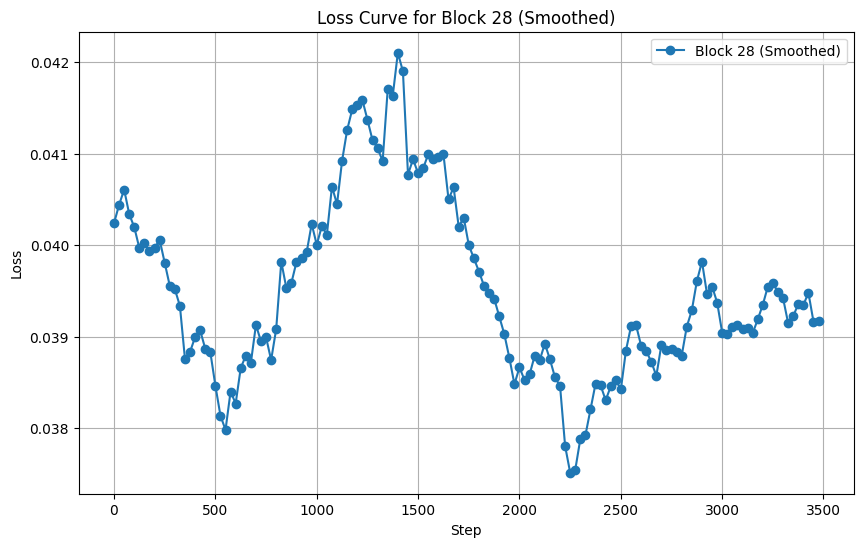

In [6]:
import csv
import os

class BlockLossRecorder:
    def __init__(self, file_path:str):
        """
        初始化 BlockLossRecorder
        :param file_path: 用于存储loss记录的文件路径
        """
        self.file_path = file_path
        self.loss_data = {}

        # 如果文件存在，则从文件中加载已有的数据
        if os.path.exists(self.file_path):
            self._load_from_file()

    def record(self, blk_id:str, step:int, loss:float):
        """
        记录指定 block 和 step 的 loss 值
        :param blk_id: block 的 ID
        :param step: 当前 step
        :param loss: 当前 step 对应的 loss
        """
        if blk_id not in self.loss_data:
            self.loss_data[blk_id] = []
        self.loss_data[blk_id].append((step, loss))

    def save_to_file(self):
        """
        将记录的 loss 数据保存到文件
        """
        with open(self.file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["blk_id", "step", "loss"])
            for blk_id, records in self.loss_data.items():
                for step, loss in records:
                    writer.writerow([blk_id, step, loss])

    def _load_from_file(self):
        """
        从文件中加载 loss 数据
        """
        with open(self.file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # 跳过表头
            for row in reader:
                blk_id, step, loss = row[0], int(row[1]), float(row[2])
                if blk_id not in self.loss_data:
                    self.loss_data[blk_id] = []
                self.loss_data[blk_id].append((step, loss))

    def get_loss_data(self, blk_id):
        """
        获取指定 block ID 对应的 loss 数据
        :param blk_id: block 的 ID
        :return: 对应的 step 和 loss 列表
        """
        return self.loss_data.get(blk_id, [])

import matplotlib.pyplot as plt
import numpy as np
def plot_loss(block_loss_data, blk_id, downsample_step=25, smoothing_window=25):
    """
    使用matplotlib绘制指定block的loss曲线，支持下采样和移动平均
    :param block_loss_data: 某个block的step和loss数据
    :param blk_id: 要绘制的block ID
    :param downsample_step: 下采样步长（每n个step显示一个点）
    :param smoothing_window: 移动平均的窗口大小
    """
    if not block_loss_data:
        print(f"没有找到 block {blk_id} 的 loss 数据")
        return

    steps, losses = zip(*block_loss_data)  # 解压出 step 和 loss

    # 进行下采样
    steps = steps[::downsample_step]
    losses = losses[::downsample_step]

    # 计算移动平均
    smooth_losses = np.convolve(losses, np.ones(smoothing_window)/smoothing_window, mode='valid')

    # 调整steps以匹配平滑后的loss长度
    smooth_steps = steps[:len(smooth_losses)]

    plt.figure(figsize=(10, 6))
    plt.plot(smooth_steps, smooth_losses, label=f'Block {blk_id} (Smoothed)', marker='o')
    # 使用散点图代替折线图
    # plt.scatter(smooth_steps, smooth_losses, label=f'Block {blk_id} (Smoothed)', marker='o')

    # 设置标题和标签
    plt.title(f'Loss Curve for Block {blk_id} (Smoothed)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# # 示例用法
# if __name__ == "__main__":
loss_dir="/home/ubuntu/data/exp/proj2410/logs"
file = os.path.join(loss_dir,"tmp.csv")
recorder = BlockLossRecorder(file)

# 读取数据用于画图
loss_data = recorder.get_loss_data("28")
print("block1的loss数据:", loss_data)

plot_loss(loss_data, "28")

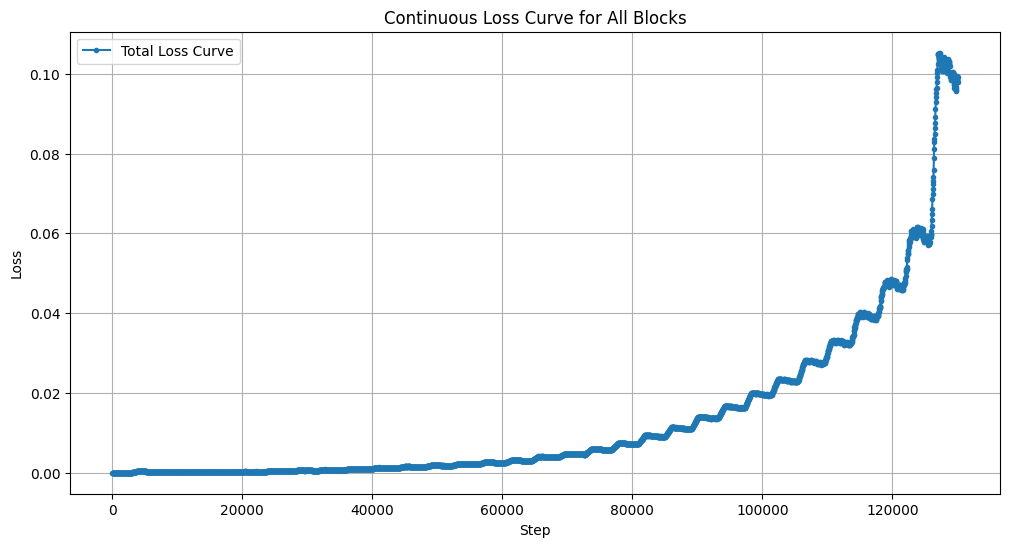

In [7]:
data=[]
for i in range(32):
    loss_data =recorder.get_loss_data(f"{i}")
    _,loss_data = zip(*loss_data)
    data.extend(loss_data)
len(data),data[0]
import matplotlib.pyplot as plt
import numpy as np

def plot_continuous_loss(loss_data, num_blocks=32, steps_per_block=4096, downsample_step=32, smoothing_window=32):
    """
    绘制所有block的连续loss曲线，支持平滑和下采样
    :param loss_data: 二维loss数据，形状为 [num_blocks, steps_per_block]
    :param num_blocks: block的数量
    :param steps_per_block: 每个block的step数量
    :param downsample_step: 下采样步长（每n个step显示一个点）
    :param smoothing_window: 平滑窗口大小
    """
    total_steps = num_blocks * steps_per_block  # 计算总步数
    all_steps = np.arange(total_steps)  # 创建总的 step 序列
    all_losses = loss_data.flatten()  # 将所有block的loss数据展平为一维数组

    # 对整体数据进行下采样
    all_steps = all_steps[::downsample_step]
    all_losses = all_losses[::downsample_step]

    # 进行移动平均
    smooth_losses = np.convolve(all_losses, np.ones(smoothing_window) / smoothing_window, mode='valid')
    smooth_steps = all_steps[:len(smooth_losses)]  # 对应调整steps

    # 绘制loss曲线
    plt.figure(figsize=(12, 6))
    plt.plot(smooth_steps, smooth_losses, label='Total Loss Curve', marker='o', markersize=3)

    # 设置标题和标签
    plt.title('Continuous Loss Curve for All Blocks')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_continuous_loss(np.array(data))

In [1]:
import torch
import gc

def get_tensor_size(tensor):
    """获取张量的内存大小，单位是字节"""
    return tensor.numel() * tensor.element_size()

def profile_memory(obj):
    """统计给定对象的内存占用，包括 nn.Module 和包含 Tensor 的其他对象"""
    total_size = 0
    device_memory = {}
    
    def process_tensor(tensor):
        """处理一个张量并更新总内存统计"""
        nonlocal total_size
        size = get_tensor_size(tensor)
        total_size += size
        device = tensor.device.type
        if device not in device_memory:
            device_memory[device] = 0
        device_memory[device] += size

    def process_object(obj):
        """递归处理对象及其属性"""
        if isinstance(obj, torch.nn.Module):
            # 处理 nn.Module 的参数和缓冲区
            for param in obj.parameters():
                process_tensor(param)
            for buffer in obj.buffers():
                process_tensor(buffer)
        elif isinstance(obj, torch.Tensor):
            # 如果对象本身就是张量
            process_tensor(obj)
        elif hasattr(obj, '__dict__'):
            # 处理其他对象，递归检查其属性
            for attr_name, attr_value in vars(obj).items():
                process_object(attr_value)
        elif isinstance(obj, list) or isinstance(obj, tuple) or isinstance(obj, set):
            # 处理容器类型
            for item in obj:
                process_object(item)
        elif isinstance(obj, dict):
            # 处理字典
            for key, value in obj.items():
                process_object(value)

    # 开始递归处理对象
    process_object(obj)

    # 计算结果
    total_mb = total_size / (1024 ** 2)
    device_memory_mb = {k: v / (1024 ** 2) for k, v in device_memory.items()}

    return {
        "total_memory_bytes": total_size,
        "total_memory_MB": total_mb,
        "device_memory_MB": device_memory_mb
    }

# Example usage:
# For nn.Module
# model = torch.nn.Linear(100, 200)
# memory_profile = profile_memory(model)
# print(memory_profile)

# # For a dataset containing Tensors
# class CustomDataset:
#     def __init__(self):
#         self.data = torch.randn(1000, 1000)
#         self.labels = torch.randint(0, 10, (1000,))

# dataset = CustomDataset()
# memory_profile = profile_memory(dataset)
# print(memory_profile)

# # 清除 PyTorch 缓存并手动运行垃圾回收器（有助于更准确的内存统计）
# torch.cuda.empty_cache()
# gc.collect()

import os

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

from template.datautils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

llm_model= AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
memory_profile = profile_memory(llm_model)
print(memory_profile)

/home/ubuntu/data/anaconda3/envs/quant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]

{'total_memory_bytes': 27020779520, 'total_memory_MB': 25769.0234375, 'device_memory_MB': {'cuda': 25769.0234375}}
